In [253]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

In [254]:
import random
import time

In [255]:
path = "./germany_dataset/train.csv"
df = pd.read_csv(path)

In [256]:
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [257]:
df.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000


In [286]:
# All Variables declaration to use same code for different datasets
num_of_classes = df["ClassId"].nunique()
resize_x  = 15
resize_y  = 15
num_of_channels = 3
directory = "./germany_dataset/"
Epochs=250

In [259]:
print("Total Training Examples : ",len(df))

Total Training Examples :  39209


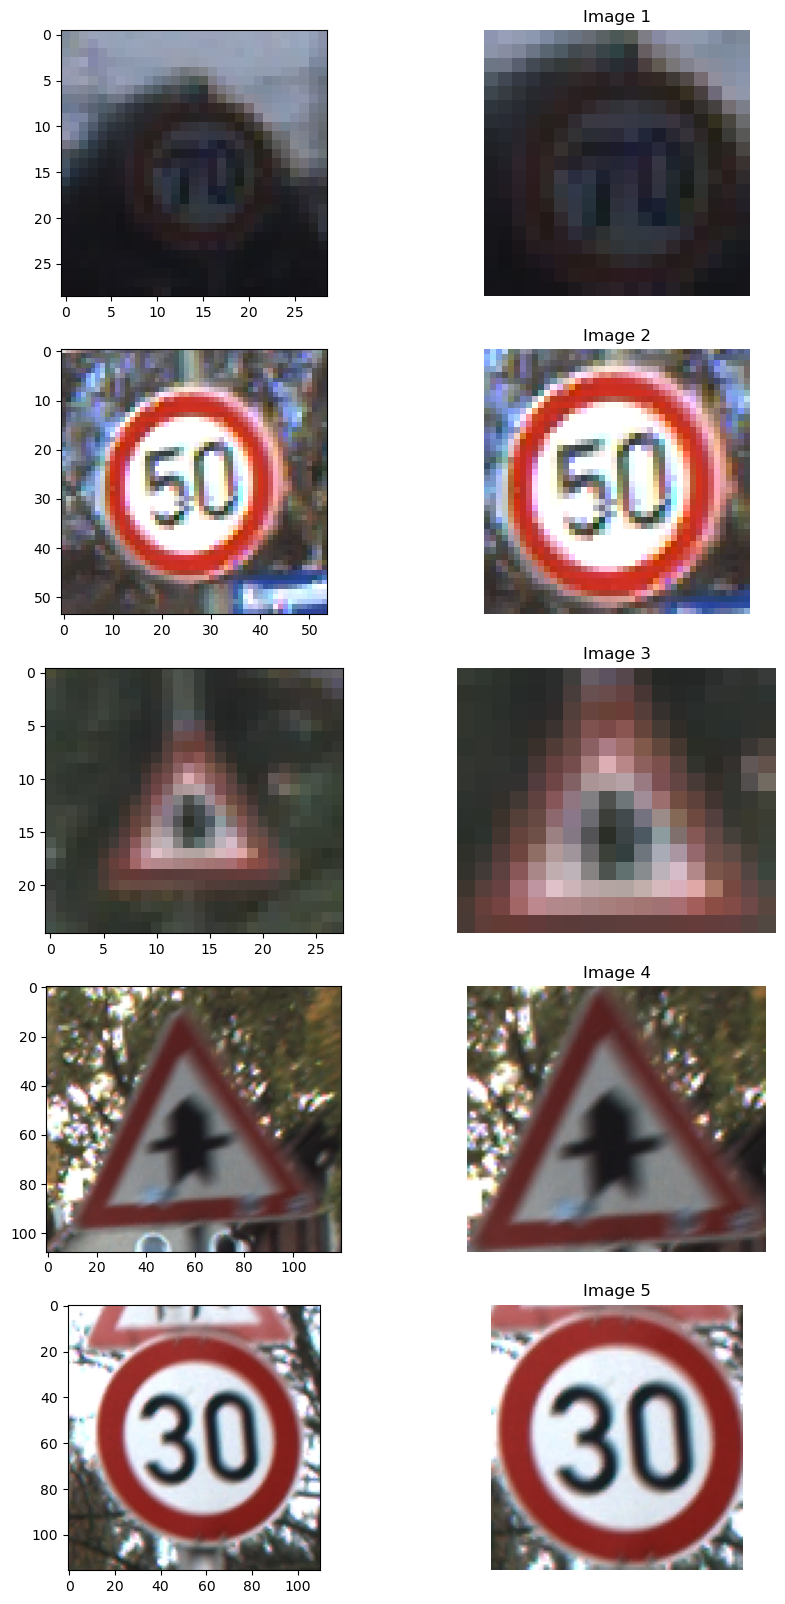

In [260]:
# Sample Images and there crop according to data given in csv
num_rows = 5
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))
total_images = []
for i in range(5):
    integer = random.randint(0,21000)
    total_images.append(df.iloc[integer].values)
total_images = list(total_images)
for i,val in enumerate(total_images):
    row = i
    col=0
    ax = axes[row, col]
    img = Image.open("./germany_dataset/"+val[7])
    ax.imshow(img)
    img = img.crop((val[2],val[3],val[4],val[5]))
    ax = axes[row,col+1]
    ax.imshow(img)
    ax.set_title(f'Image {i + 1}')
    ax.axis('off')

Total Training Examples :  39209


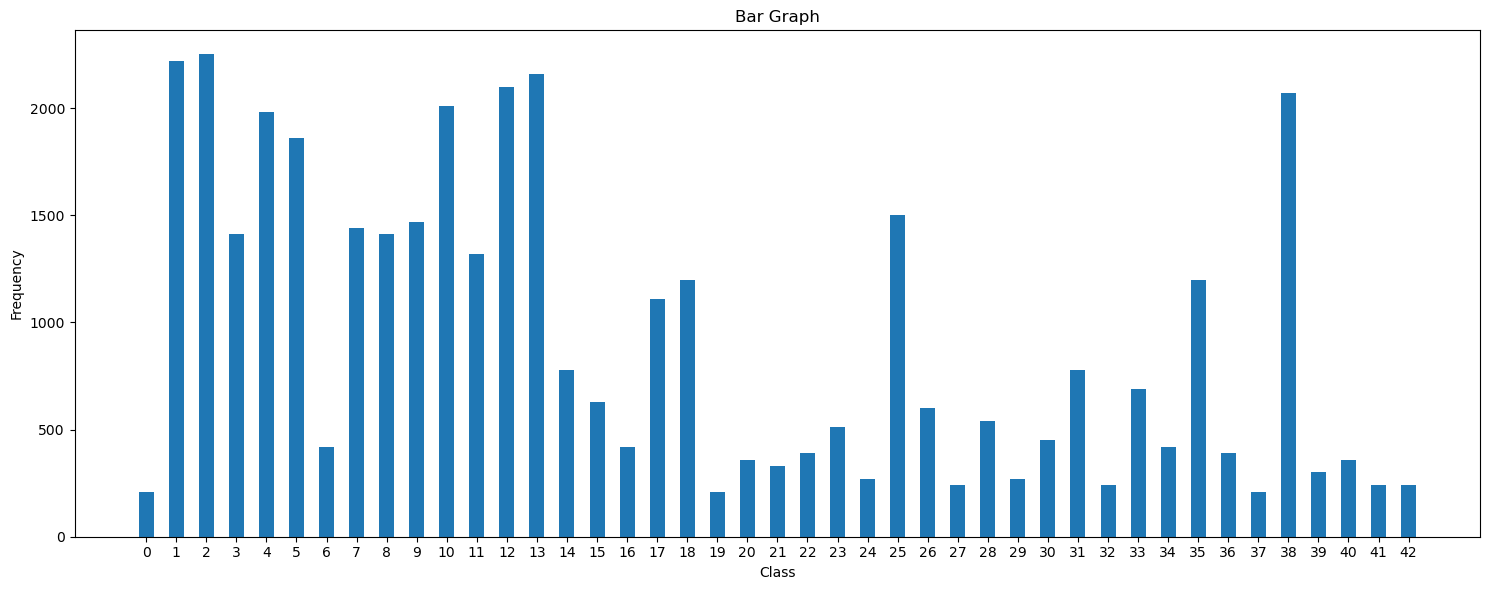

In [261]:
#Statistics of Data
print("Total Training Examples : ",len(df))
values = df["ClassId"].value_counts()
x_labels = [str(x) for x in range(43)]
y_labels = []
for x in range(43):
    y_labels.append(values[x])
plt.figure(figsize=(15, 6))
plt.bar(x_labels,y_labels,width=0.5)
plt.title('Bar Graph')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [262]:
# Necessary Functions

def get_max_index(arr):
    length = len(arr)
    mini = 0
    value = 0
    for i,val in enumerate(arr):
        if mini < val :
            mini = val
            value = i
    return value

def Predict_for_single_example(model,img):
    img  = np.array(img)
    img  = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    img = tf.expand_dims(img, axis=0)
    probability = model.predict(img)
    value = get_max_index(probability[0])
    return value
    
def Predict_for_Multiple_examples(model,images):
    img = np.array(images)
    img = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    probability = model.predict(img)
    values = []
    for val in probability:
        values.append(get_max_index(val))
    return values

In [263]:
class Data:
    def __init__(self,df,size_x,size_y):
        self.df = df
        self.root = "./germany_dataset/"
        self.resize_x = size_x
        self.resize_y = size_y
    
    def Do_Crop(self,path,x1,y1,x2,y2):
        img = Image.open(self.root+path)
        img = img.crop((x1,y1,x2,y2))
        return img.resize((self.resize_x,self.resize_y))
    
    def Row_Data(self,row):
        self.X.append(self.Do_Crop(row[7],row[2],row[3],row[4],row[5]))
        self.Y.append(int(row[6]))
    
    def Get_Data(self):
        self.X = []
        self.Y = []
        for index, row in df.iterrows():
            self.Row_Data(row)

In [264]:
# Reading images from local storage
starting_time = time.time()

data = Data(df,resize_x,resize_y)
data.Get_Data()

ending_time = time.time()
total_time = ending_time - starting_time
total_time/=60

print("Time taken to read images : ",total_time," min")

Time taken to read images :  0.5370457530021667  min


In [265]:
# Up-sampling the images

starting_time = time.time()
#Storing in dictionary
classes = {}

for val in range(num_of_classes):
    classes[val]=[]

max_repeating = 0;

for i,label in enumerate(data.Y):
    classes[label].append(data.X[i])

for key in classes:
    max_repeating = max(max_repeating,len(classes[key]))

for i in range(num_of_classes):
    length = len(classes[i])
    upsample_count = max_repeating - length
    for j in range(upsample_count):
        select_image = random.randint(0,length-1)
        angle = random.randint(0,359)
        classes[i].append(classes[i][select_image].rotate(angle).resize((resize_x,resize_y)))

ending_time = time.time()
total_time = ending_time - starting_time
total_time/=60

print("Time taken to upsample images : ",total_time," min")

Time taken to upsample images :  0.053471191724141436  min


(-0.5, 14.5, 14.5, -0.5)

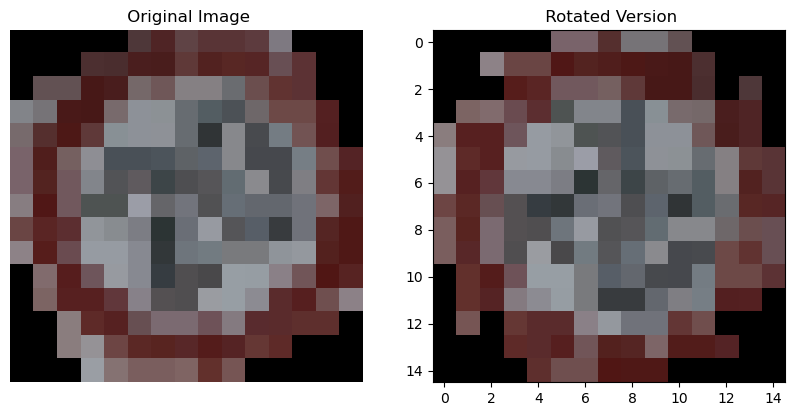

In [400]:
# Up-sampling example image

random_class = random.randint(0,num_of_classes)
length = len(classes[random_class])
random_image = random.randint(0,length-1)
img = classes[random_class][random_image]
fig, axes = plt.subplots(1, 2, figsize=(10, 20))
ax = axes[0]
axes[0].set_title(f' Original Image')
ax.imshow(img)
angle = random.randint(1,359)
img = img.rotate(angle).resize((resize_x,resize_y))
axes[1].imshow(img)
axes[1].set_title(f' Rotated Version')
ax.axis('off')

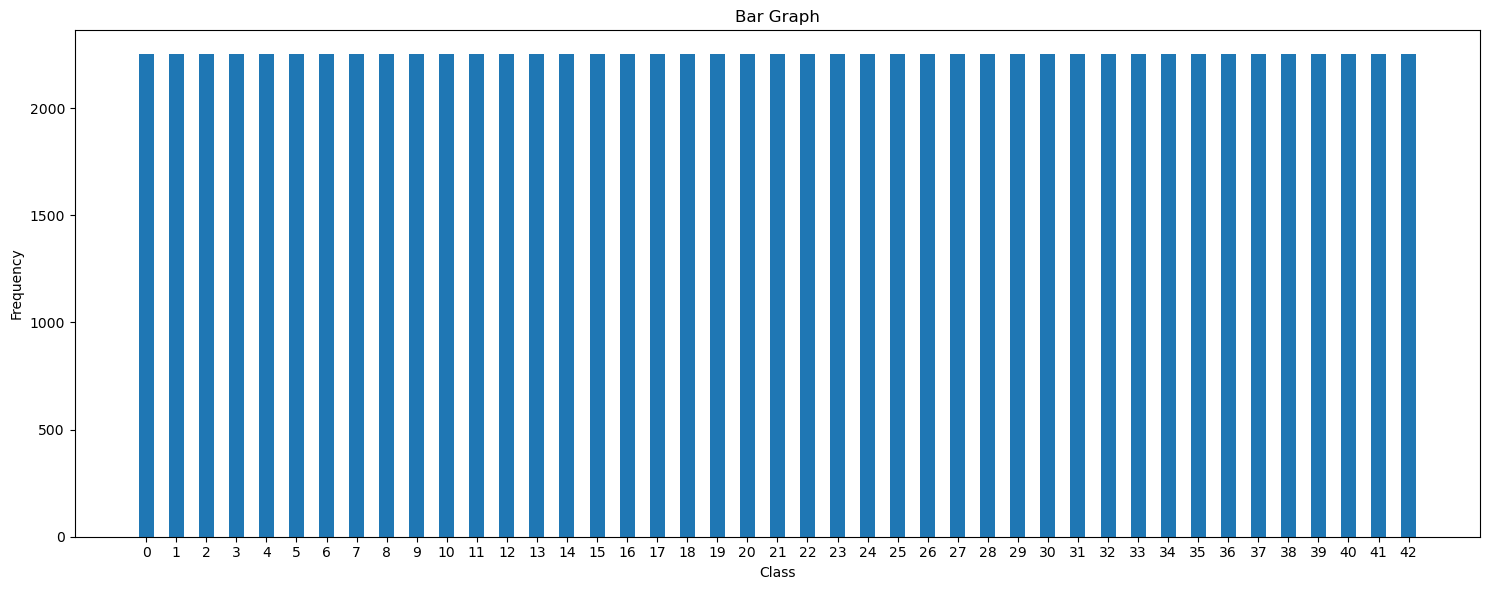

In [267]:
x_labels = [str(x) for x in range(num_of_classes)]
y_labels = []
for i in (classes):
    y_labels.append(len(classes[i]))
plt.figure(figsize=(15, 6))
plt.bar(x_labels,y_labels,width=0.5)
plt.title('Bar Graph')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [268]:
# Declaring X_train and Y_train and Re arranging the values

starting_time = time.time()

X_train = []
Y_train = []

for i in range(num_of_classes):
    for j,val in enumerate(classes[i]):
        X_train.append(np.array(val))
        Y_train.append(i)

array_pairs = list(zip(X_train, Y_train))

# Shuffle the pairs
shuffled_pairs = np.random.permutation(array_pairs)

X_train, Y_train = zip(*shuffled_pairs)

X_train = tf.convert_to_tensor(np.array(X_train),dtype=float)
Y_train = tf.convert_to_tensor(np.array(Y_train),dtype=float)


ending_time = time.time()
total_time = ending_time - starting_time
total_time/=60

print("Time taken to convert into tensor : ",total_time," min")

C:\Users\gajul\AppData\Local\Temp\ipykernel_10920\170726535.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  shuffled_pairs = np.random.permutation(array_pairs)


Time taken to convert into tensor :  0.08738420009613038  min


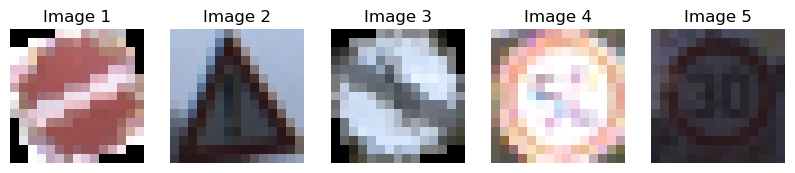

In [388]:
fig, axes = plt.subplots(1, 5, figsize=(10, 20))
length = len(X_train)
for i in range(5):
    col=i
    ax = axes[col]
    random_integer = random.randint(0,length-1)
    img = X_train[random_integer]
    ax.imshow(img)
    ax.set_title(f'Image {i + 1}')
    ax.axis('off')

In [270]:
#Data_Augmentation
X_train = X_train/255.0

In [271]:
Y_train = to_categorical(Y_train)

In [272]:
# Implementation of ANN
model = Sequential()
model.add(Flatten(input_shape=(resize_x, resize_y, num_of_channels)))
model.add(Dense(64, activation='relu'))
model.add(Dense(43, activation='softmax'))

In [273]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [285]:
starting_time = time.time()

history = model.fit(X_train,Y_train,epochs=Epochs,batch_size=32,validation_split=0.3)

ending_time = time.time()
total_time = ending_time - starting_time
total_time/=60

print("Time taken fit : ",total_time," min")

Epoch 1/250
2117/2117 [==============================] - 9s 4ms/step - loss: 0.5090 - accuracy: 0.8487 - val_loss: 0.7005 - val_accuracy: 0.8162
Epoch 2/250
2117/2117 [==============================] - 8s 4ms/step - loss: 0.5073 - accuracy: 0.8512 - val_loss: 0.7173 - val_accuracy: 0.8128
Epoch 3/250
2117/2117 [==============================] - 8s 4ms/step - loss: 0.5064 - accuracy: 0.8504 - val_loss: 0.7410 - val_accuracy: 0.8054
Epoch 4/250
2117/2117 [==============================] - 8s 4ms/step - loss: 0.5052 - accuracy: 0.8510 - val_loss: 0.7219 - val_accuracy: 0.8079
Epoch 5/250
2117/2117 [==============================] - 7s 3ms/step - loss: 0.5059 - accuracy: 0.8503 - val_loss: 0.7004 - val_accuracy: 0.8156
Epoch 6/250
2117/2117 [==============================] - 7s 3ms/step - loss: 0.5031 - accuracy: 0.8511 - val_loss: 0.7583 - val_accuracy: 0.8004
Epoch 7/250
2117/2117 [==============================] - 7s 3ms/step - loss: 0.5044 - accuracy: 0.8517 - val_loss: 0.7218 - val_ac

2117/2117 [==============================] - 7s 3ms/step - loss: 0.4695 - accuracy: 0.8602 - val_loss: 0.7537 - val_accuracy: 0.8060
Epoch 58/250
2117/2117 [==============================] - 7s 3ms/step - loss: 0.4721 - accuracy: 0.8605 - val_loss: 0.7071 - val_accuracy: 0.8202
Epoch 59/250
2117/2117 [==============================] - 7s 4ms/step - loss: 0.4731 - accuracy: 0.8601 - val_loss: 0.7276 - val_accuracy: 0.8145
Epoch 60/250
2117/2117 [==============================] - 8s 4ms/step - loss: 0.4695 - accuracy: 0.8610 - val_loss: 0.7296 - val_accuracy: 0.8145
Epoch 61/250
2117/2117 [==============================] - 7s 3ms/step - loss: 0.4690 - accuracy: 0.8618 - val_loss: 0.6985 - val_accuracy: 0.8234
Epoch 62/250
2117/2117 [==============================] - 8s 4ms/step - loss: 0.4684 - accuracy: 0.8615 - val_loss: 0.7438 - val_accuracy: 0.8131
Epoch 63/250
2117/2117 [==============================] - 8s 4ms/step - loss: 0.4685 - accuracy: 0.8602 - val_loss: 0.7243 - val_accuracy

2117/2117 [==============================] - 8s 4ms/step - loss: 0.4493 - accuracy: 0.8655 - val_loss: 0.7033 - val_accuracy: 0.8226
Epoch 114/250
2117/2117 [==============================] - 8s 4ms/step - loss: 0.4432 - accuracy: 0.8690 - val_loss: 0.6997 - val_accuracy: 0.8234
Epoch 115/250
2117/2117 [==============================] - 8s 4ms/step - loss: 0.4422 - accuracy: 0.8681 - val_loss: 0.6990 - val_accuracy: 0.8241
Epoch 116/250
2117/2117 [==============================] - 8s 4ms/step - loss: 0.4426 - accuracy: 0.8692 - val_loss: 0.7108 - val_accuracy: 0.8193
Epoch 117/250
2117/2117 [==============================] - 8s 4ms/step - loss: 0.4464 - accuracy: 0.8672 - val_loss: 0.7218 - val_accuracy: 0.8166
Epoch 118/250
2117/2117 [==============================] - 9s 4ms/step - loss: 0.4430 - accuracy: 0.8676 - val_loss: 0.7066 - val_accuracy: 0.8214
Epoch 119/250
2117/2117 [==============================] - 8s 4ms/step - loss: 0.4417 - accuracy: 0.8679 - val_loss: 0.7179 - val_ac

Epoch 169/250
2117/2117 [==============================] - 7s 3ms/step - loss: 0.4247 - accuracy: 0.8729 - val_loss: 0.7341 - val_accuracy: 0.8181
Epoch 170/250
2117/2117 [==============================] - 7s 3ms/step - loss: 0.4220 - accuracy: 0.8742 - val_loss: 0.7194 - val_accuracy: 0.8242
Epoch 171/250
2117/2117 [==============================] - 9s 4ms/step - loss: 0.4226 - accuracy: 0.8734 - val_loss: 0.7511 - val_accuracy: 0.8171
Epoch 172/250
2117/2117 [==============================] - 8s 4ms/step - loss: 0.4225 - accuracy: 0.8732 - val_loss: 0.6986 - val_accuracy: 0.8301
Epoch 173/250
2117/2117 [==============================] - 8s 4ms/step - loss: 0.4234 - accuracy: 0.8730 - val_loss: 0.6909 - val_accuracy: 0.8296
Epoch 174/250
2117/2117 [==============================] - 8s 4ms/step - loss: 0.4207 - accuracy: 0.8746 - val_loss: 0.7296 - val_accuracy: 0.8239
Epoch 175/250
2117/2117 [==============================] - 8s 4ms/step - loss: 0.4235 - accuracy: 0.8740 - val_loss: 0

2117/2117 [==============================] - 10s 5ms/step - loss: 0.4078 - accuracy: 0.8782 - val_loss: 0.7569 - val_accuracy: 0.8168
Epoch 225/250
2117/2117 [==============================] - 12s 6ms/step - loss: 0.4050 - accuracy: 0.8790 - val_loss: 0.7203 - val_accuracy: 0.8239
Epoch 226/250
2117/2117 [==============================] - 11s 5ms/step - loss: 0.4054 - accuracy: 0.8793 - val_loss: 0.7159 - val_accuracy: 0.8297
Epoch 227/250
2117/2117 [==============================] - 9s 4ms/step - loss: 0.4081 - accuracy: 0.8767 - val_loss: 0.7205 - val_accuracy: 0.8299
Epoch 228/250
2117/2117 [==============================] - 8s 4ms/step - loss: 0.4049 - accuracy: 0.8786 - val_loss: 0.7338 - val_accuracy: 0.8232
Epoch 229/250
2117/2117 [==============================] - 9s 4ms/step - loss: 0.4054 - accuracy: 0.8790 - val_loss: 0.7527 - val_accuracy: 0.8202
Epoch 230/250
2117/2117 [==============================] - 10s 5ms/step - loss: 0.4043 - accuracy: 0.8790 - val_loss: 0.7242 - va

In [287]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

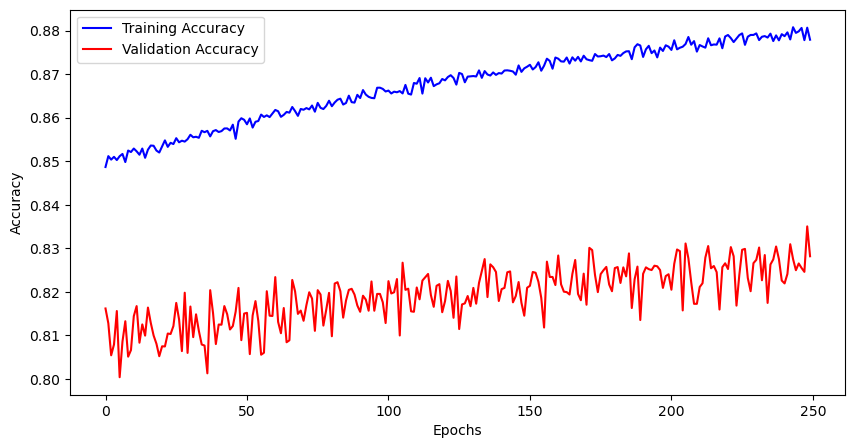

In [323]:
epochs  = [x for x in range(Epochs)]
plt.figure(figsize=(10,5))
plt.plot(epochs,training_accuracy,color="blue",label="Training Accuracy")
plt.plot(epochs,validation_accuracy,color="red",label="Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

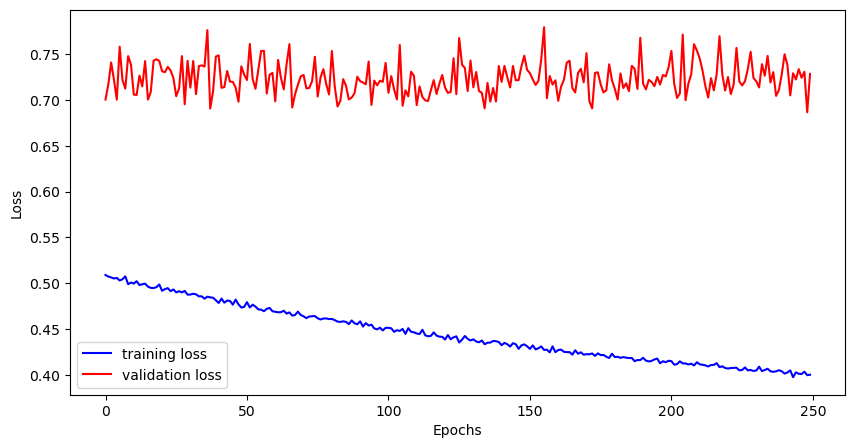

In [324]:
epochs  = [x for x in range(Epochs)]
plt.figure(figsize=(10,5))
plt.plot(epochs,loss,color="blue",label="training loss")
plt.plot(epochs,val_loss,color="red",label="validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

 ***Test Image Classification and Accuracy Calculation***

In [290]:
df_test = pd.read_csv("./germany_dataset/test.csv")
print("Number of Test Images are ", len(df_test))
df_test.head()

Number of Test Images are  12630


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


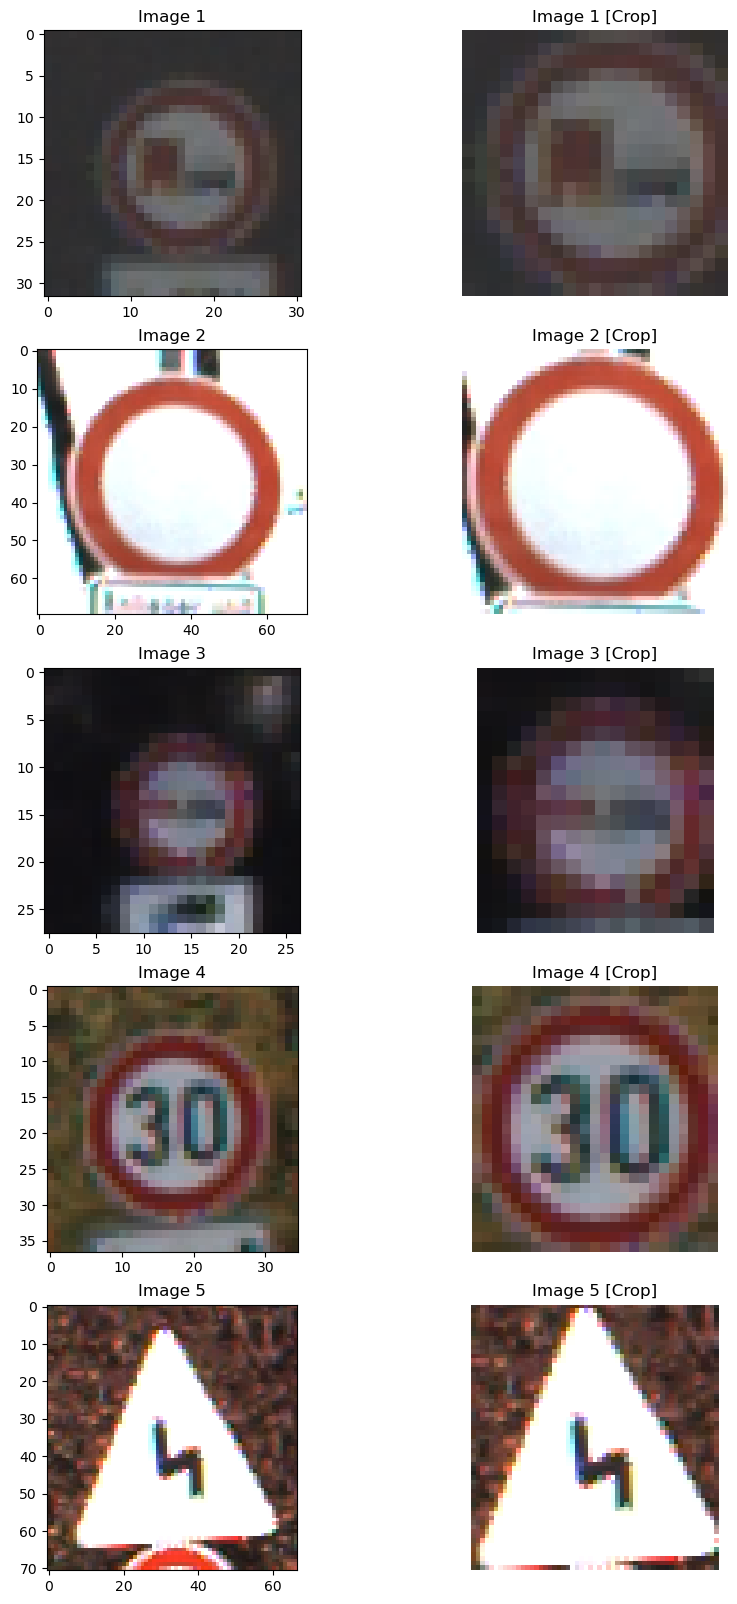

In [341]:
# Sample Images and there crop according to data given in test.csv
num_rows = 5
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))
total_images = []
for i in range(5):
    integer = random.randint(0,12630)
    total_images.append(df_test.iloc[integer].values)
total_images = list(total_images)
for i,val in enumerate(total_images):
    row = i
    col=0
    ax = axes[row, col]
    img = Image.open("./germany_dataset/"+val[7])
    ax.imshow(img)
    ax.set_title(f'Image {i + 1}')
    img = img.crop((val[2],val[3],val[4],val[5]))
    ax = axes[row,col+1]
    ax.imshow(img)
    ax.set_title(f'Image {i + 1} [Crop]')
    ax.axis('off')

In [293]:
# Test Images Prediction

images = []
test_length = len(df_test.values)
for row in df_test.values:
    img = Image.open("./germany_dataset/"+row[7])
    img = img.crop((row[2],row[3],row[4],row[5]))
    img = img.resize((resize_x,resize_y))
    img = np.array(img)
    images.append(img)
y_predicted = Predict_for_Multiple_examples(model,images)

395/395 [==============================] - 1s 2ms/step


In [296]:
# Test Accuracy Determination

y_test = df_test.iloc[:,6].values
total_correct = 0;
for i in range(test_length):
    if y_predicted[i] == y_test[i]:
        total_correct=total_correct+1
accuracy = total_correct/test_length
print("Final Test Accuracy : ",accuracy*100," %")

Test Accuracy :  79.67537608867775  %


Original Value :  8
1/1 [==============================] - 0s 28ms/step
Predicted Value :  5


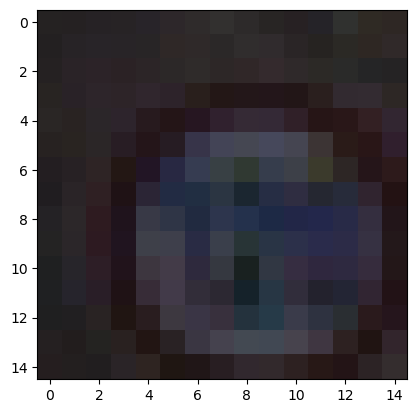

In [375]:
# Testing one Random Image from test data 

select_row=random.randint(0,12629)
row = df_test.iloc[select_row]
print("Original Value : ",df_test.iloc[select_row,6])
img = Image.open("./germany_dataset/"+row[7])
img = img.crop((row[2],row[3],row[4],row[5]))
img = img.resize((resize_x,resize_y))
plt.imshow(img)
img  = np.array(img)
img  = tf.convert_to_tensor(img,dtype=float)
img = img/255.0
img = tf.expand_dims(img, axis=0)
probability = model.predict(img)
value = get_max_index(probability[0])
print("Predicted Value : ",value)